In [209]:
import re

import torch
import pandas as pd

from helpers.forward_pass import *
from helpers.backward_pass import *

from helpers.weight_util import *

In [210]:
# df = pd.read_csv("https://raw.githubusercontent.com/amitness/gender-data/refs/heads/master/genders.csv")
df = pd.read_csv("names.csv")
df = pd.DataFrame(df)
# df["name"] = df["name"].apply(lambda x: re.sub(r"\(.*?\)", "", x))
names = df.name.unique()

In [211]:
vowels = ["."] + sorted(list(set("".join(names))))
char_to_ix = {
    ch: i for i, ch in enumerate(vowels)
}
ix_to_char = {
    i: ch for i, ch in enumerate(vowels)
}
ix_to_char

{0: '.',
 1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z'}

In [212]:
block_size = 3
for nm in names[:2]:
  block = ["."] * block_size
  nm = nm + "."
  print(nm)
  for ch in nm:
    print(block, ch)
    block = block[1:] + [ch]

aabha.
['.', '.', '.'] a
['.', '.', 'a'] a
['.', 'a', 'a'] b
['a', 'a', 'b'] h
['a', 'b', 'h'] a
['b', 'h', 'a'] .
aabhas.
['.', '.', '.'] a
['.', '.', 'a'] a
['.', 'a', 'a'] b
['a', 'a', 'b'] h
['a', 'b', 'h'] a
['b', 'h', 'a'] s
['h', 'a', 's'] .


In [213]:
def generate_data(data, block_size):
  X = []
  Y = []
  for d in data:
    block = [0] * block_size
    d = d + "." # to indicate the end of a nmae
    for ch in d:
      X.append(block)
      Y.append(char_to_ix[ch])
      block = block[1:] + [char_to_ix[ch]]
  # X, Y = torch.tensor(X), torch.tensor(Y)
  X, Y = np.array(X), np.array(Y)
  return X, Y

In [214]:
total_names = len(names)
num_train, num_test = round(0.8 * total_names), round(0.2 * total_names)

block_size = 3

X_train, Y_train = generate_data(names[:num_train], block_size)
X_test, Y_test = generate_data(names[num_train:], block_size)

X_train[:2]

array([[0, 0, 0],
       [0, 0, 1]])

In [215]:
V = len(vowels); D = 10; seed = 42
# seed = 2147483647

init_method="xavier"
# char_embeddings = torch.randn(V, D)
char_embeddings = initialize_weight((V, D), init_method, seed)

hidden = 300

W1 = initialize_weight((block_size * D, hidden), init_method, seed)
b1 = np.zeros(hidden)

W2 = initialize_weight((hidden, V), init_method, seed)
b2 = np.zeros(V)

gamma = initialize_weight((hidden,))
beta = initialize_weight((hidden,))

bn_param = {
  "mode": "train"
}


In [216]:

# learning_exp = np.linspace(-3, -1.5, 1000)
# learning_rates = 10**learning_exp

N, block_size = X_train.shape
batch_size = 100

loss_history = []
# lr_history = []

# embed -> affine -> tanh -> affine -> softmax
for i in range(4000):
  random_indices = np.random.randint(0, N, (batch_size,))
  # word embedding
  out, embed_cache = word_embedding_forward(X_train[random_indices], char_embeddings)

  # affine
  out, cache1 = affine_forward(out, W1, b1)

  # batch norm
  out, bn1_cache = batchnorm_forward(out, gamma, beta, bn_param)

  # tanh
  out, tan_cache = tanh_forward(out)

  # affine
  out, cache2 = affine_forward(out, W2, b2)

  loss, dscores = softmax_loss(out, Y_train[random_indices])
  loss_history.append(loss)
  # lr_history.append(learning_exp[i])

  if i % 100 == 0:
    print(f"Loss at iteration: {i} -> {loss}")

  # --------------------------------
  #         backward pass
  # --------------------------------

  dx, dw, db = affine_backward(dscores, cache2)

  lr = 0.02
  W2 -= lr * dw
  b2 -= lr * db

  dx = tanh_backward(dx, tan_cache)

  dx, dgamma, dbeta = batchnorm_backward(dx, bn1_cache)

  gamma -= lr * dgamma
  dbeta -= lr * dbeta

  dx, dw, db = affine_backward(dx, cache1)

  W1 -= lr * dw
  b1 -= lr * db

  dx = dx.reshape(batch_size, block_size, D)

  dw = word_embedding_backward(dx, embed_cache)

  char_embeddings -= lr * dw


Loss at iteration: 0 -> 3.693741231426502


Loss at iteration: 100 -> 14.024120572009968
Loss at iteration: 200 -> 9.602049600718104
Loss at iteration: 300 -> 8.585671751403112
Loss at iteration: 400 -> 8.160155708542035
Loss at iteration: 500 -> 6.378783111871351
Loss at iteration: 600 -> 7.335843460954354
Loss at iteration: 700 -> 6.530575197286671
Loss at iteration: 800 -> 7.663986353808747
Loss at iteration: 900 -> 7.468126703030595
Loss at iteration: 1000 -> 7.3653880631992195
Loss at iteration: 1100 -> 4.39978755483137
Loss at iteration: 1200 -> 5.965367814253037
Loss at iteration: 1300 -> 6.5687861460477155
Loss at iteration: 1400 -> 6.745023446535259
Loss at iteration: 1500 -> 5.043217434122305
Loss at iteration: 1600 -> 6.454667701346409
Loss at iteration: 1700 -> 5.533892153793918
Loss at iteration: 1800 -> 8.989631508218295
Loss at iteration: 1900 -> 5.174046702369765
Loss at iteration: 2000 -> 8.109070264431686
Loss at iteration: 2100 -> 4.7703754387409365
Loss at iteration: 2200 -> 6.404032648340649
Loss at iteratio

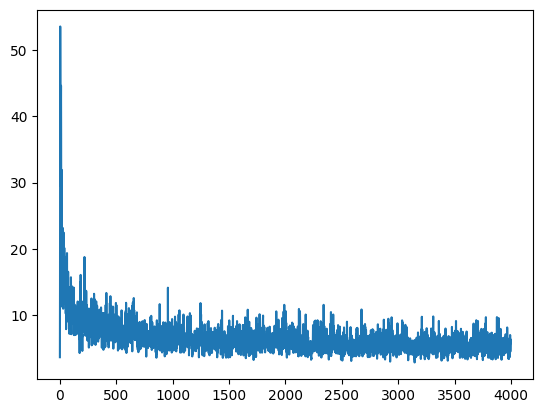

In [217]:
import matplotlib.pyplot as plt

# plt.plot(lr_history, loss_history)
plt.plot(loss_history)
plt.show()

In [218]:
bn_param.keys()

dict_keys(['mode', 'running_mean', 'running_var'])

In [260]:
# sampling
np.random.seed(None)
num_samples = 10
for _ in range(num_samples):
  output = []
  name = [0] * block_size
  while True:
    name_ = np.array(name).reshape(1, block_size)

    out, _ = word_embedding_forward(name_, char_embeddings)

    # affine
    out, _ = affine_forward(out, W1, b1)

    # batch normalization
    bn_param["mode"] = "test"
    out, _ = batchnorm_forward(out, gamma, beta, bn_param)

    # tanh
    out, _ = tanh_forward(out)

    # affine
    out, _ = affine_forward(out, W2, b2)

    dscores = softmax_loss(out)
    index = np.random.choice(a=V, size=1, p=dscores[0]).item()

    if index == 0:
      break

    name = name[1:] + [index]
    output.append(index)
  print(''.join(ix_to_char[ix] for ix in output))


prabinni
manishwarishaiila
prawishna
pramin
pramenasamisangoya
praya
prasisasali
prathatiavishaiwashna
prahendra
pramindra


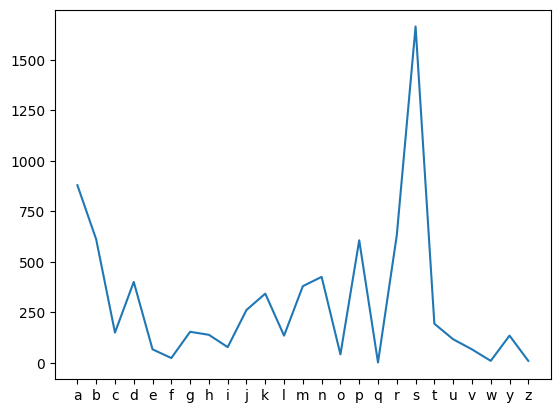

In [220]:
count = {}
for nm in names:
  if nm[0] in count:
    count[nm[0]] += 1
  else:
    count[nm[0]] = 1

plt.plot(count.keys(), count.values())